# CoDA in 2ACDC near/far — Fig. 4c/4i/4j (OSM‑style)

This notebook mirrors the OSM figure notebooks’ structure and produces:
- **Fig. 4c**: a clean transition graph with a layered layout (base / near / far),
- **Fig. 4i**: final correlation quantification (block means), and
- **Fig. 4j**: decorrelation order (time to corr < 0.3).


In [1]:

import math, random, collections
from dataclasses import dataclass
from typing import Dict, List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

random.seed(0); np.random.seed(0)


## Task (Sun et al.) — near/far symbol sequences and key blocks

In [2]:

near = [1,1,1,1,1,1, 2,2,2,2, 1,1,1, 4, 6, 1,1,1, 5,5, 1,1, 7, 0,0,0]
far  = [1,1,1,1,1,1, 3,3,3,3, 1,1,1, 4,4, 1,1,1, 5, 6, 1,1, 7, 0,0,0]
assert len(near)==len(far)==26

preR1_idx = list(range(10,13))
preR2_idx = list(range(15,18))

def block_indices(rows, cols): return [(r,c) for r in rows for c in cols]
offdiag_pairs     = block_indices(preR1_idx, preR2_idx) + block_indices(preR2_idx, preR1_idx)
same_preR1_pairs  = block_indices(preR1_idx, preR1_idx)
same_preR2_pairs  = block_indices(preR2_idx, preR2_idx)

symbols = sorted(set(near)|set(far))


## Minimal CoDA (tabular)

In [3]:

@dataclass
class LatentState:
    id: int
    obs: int
    path: Optional[str] = None
    parent: Optional[int] = None

class CoDAAgent:
    def __init__(self, obs_symbols, gamma=0.9, lam=0.8, theta_split=0.9, theta_merge=0.5):
        self.gamma = gamma; self.lam = lam
        self.theta_split = theta_split; self.theta_merge = theta_merge
        self.reset_symbols = {0}
        self.states: Dict[int, LatentState] = {}
        self.obs_to_state_ids: Dict[int, List[int]] = {o: [] for o in obs_symbols}
        sid = 0
        for o in obs_symbols:
            st = LatentState(id=sid, obs=o, path=None, parent=None)
            self.states[sid] = st
            self.obs_to_state_ids[o].append(sid)
            sid += 1
        self._next_sid = sid
        self.edge_counts = collections.Counter()
        self.us_classes = [4,5]  # visual R1, visual R2
        self.co_occ = {s: {u: 0.0 for u in self.us_classes} for s in self.states}
        self.state_exposure = collections.Counter()
        self.salient: Dict[int, str] = {}
    
    def _ensure_state_keys(self, sid):
        if sid not in self.co_occ:
            self.co_occ[sid] = {u:0.0 for u in self.us_classes}
        if sid not in self.state_exposure:
            self.state_exposure[sid] = 0.0
    
    def _clone_state(self, orig_state_id: int, path: str) -> int:
        orig = self.states[orig_state_id]
        clone_id = self._next_sid
        clone = LatentState(id=clone_id, obs=orig.obs, path=path, parent=orig_state_id)
        self.states[clone_id] = clone
        self.obs_to_state_ids[orig.obs].append(clone_id)
        self._ensure_state_keys(clone_id)
        self._next_sid += 1
        return clone_id
    
    def _select_state_for_obs(self, obs: int, current_context: Optional[str]) -> int:
        cands = self.obs_to_state_ids[obs]
        if current_context is not None:
            for sid in cands:
                if self.states[sid].path == current_context:
                    return sid
        for sid in cands:
            if self.states[sid].path is None:
                return sid
        return cands[0]
    
    def run_episode(self, obs_seq: List[int], learn=True):
        context = None
        latent_seq = []
        for obs in obs_seq:
            sid = self._select_state_for_obs(obs, context)
            latent_seq.append(sid)
            if sid in self.salient:
                context = self.salient[sid]
            if obs in self.reset_symbols:
                context = None
        
        if not learn: return latent_seq
        
        # US events
        us_positions = {4: [i for i,o in enumerate(obs_seq) if o==4],
                        5: [i for i,o in enumerate(obs_seq) if o==5]}
        # contextual eligibilities
        for u, pos_list in us_positions.items():
            for t_us in pos_list:
                e = np.zeros(max(self.states)+1, dtype=float)
                for t in range(t_us+1):
                    sid = latent_seq[t]
                    e *= (self.gamma * self.lam)
                    e[sid] += 1.0
                    self.state_exposure[sid] += e[sid]
                for s_id, val in enumerate(e):
                    if val>0 and s_id in self.states:
                        self._ensure_state_keys(s_id)
                        self.co_occ[s_id][u] += val
        
        # Prospective contingency and splitting
        P = {}
        for s in list(self.states.keys()):
            self._ensure_state_keys(s)
            tot = sum(self.co_occ[s][u] for u in self.us_classes)
            P[s] = {u:(self.co_occ[s][u]/tot if tot>0 else 0.0) for u in self.us_classes}
        
        newly_salient = []
        for s in list(self.states.keys()):
            if s in self.salient: continue
            if sum(self.co_occ[s].values())<=0: continue
            u_star = max(self.us_classes, key=lambda u: P[s][u])
            if P[s][u_star] > self.theta_split:
                path = 'R1' if u_star==4 else 'R2'
                self.salient[s] = path
                newly_salient.append((s, path))
        
        # Clone immediate successors along the marked path
        for s, path in newly_salient:
            # reconstruct this episode's latent sequence (no learning) to find successors
            context=None
            lat = []
            for obs in obs_seq:
                sid = self._select_state_for_obs(obs, context)
                lat.append(sid)
                if sid in self.salient: context=self.salient[sid]
                if obs in self.reset_symbols: context=None
            idxs = [i for i,sid in enumerate(lat[:-1]) if sid==s]
            for i in idxs:
                next_obs = obs_seq[i+1]
                cands = self.obs_to_state_ids[next_obs]
                if not any(self.states[c].path==path for c in cands):
                    self._clone_state(cands[0], path)
        
        return latent_seq
    
    def encode_sequence(self, obs_seq: List[int]) -> np.ndarray:
        lat = self.run_episode(obs_seq, learn=False)
        S = max(self.states)+1
        X = np.zeros((len(lat), S), dtype=float)
        for t, sid in enumerate(lat):
            X[t, sid] = 1.0
        return X[:, :len(self.states)]
    
    def near_far_corr(self, near_seq, far_seq) -> np.ndarray:
        A = self.encode_sequence(near_seq); B = self.encode_sequence(far_seq)
        C = np.zeros((A.shape[0], B.shape[0]))
        for i in range(A.shape[0]):
            for j in range(B.shape[0]):
                a = A[i]; b = B[j]
                if np.allclose(a,0) or np.allclose(b,0):
                    C[i,j] = 0.0
                else:
                    a0 = a - a.mean(); b0 = b - b.mean()
                    denom = (np.linalg.norm(a0)*np.linalg.norm(b0))
                    C[i,j] = (a0@b0)/denom if denom>0 else 0.0
        return C


## Train CoDA across sessions and runs; cache matrices for Fig. 4i/4j

In [4]:

N_RUNS = 8
SESSIONS = 9
TRIALS_PER_SESSION = 80
THRESH = 0.3

def block_mean(C, pairs): 
    return float(np.mean([C[i,j] for (i,j) in pairs])) if pairs else np.nan

rng = np.random.default_rng(123)
all_final_blocks = []
all_time_to_thr = []
mat_by_session = {s: [] for s in [1,3,4,9]}

for run in range(N_RUNS):
    agent = CoDAAgent(obs_symbols=sorted(set(near)|set(far)))
    tt = {'offdiag': None, 'preR2': None, 'preR1': None}
    for session in range(1, SESSIONS+1):
        episodes = [near]*(TRIALS_PER_SESSION//2) + [far]*(TRIALS_PER_SESSION//2)
        rng.shuffle(episodes)
        for ep in episodes:
            agent.run_episode(ep, learn=True)
        C = agent.near_far_corr(near, far)
        if session in mat_by_session:
            mat_by_session[session].append(C)
        b_off = block_mean(C, offdiag_pairs)
        b_r2  = block_mean(C, same_preR2_pairs)
        b_r1  = block_mean(C, same_preR1_pairs)
        if tt['offdiag'] is None and b_off < THRESH: tt['offdiag'] = session
        if tt['preR2']  is None and b_r2  < THRESH: tt['preR2']  = session
        if tt['preR1']  is None and b_r1  < THRESH: tt['preR1']  = session
    # Final
    C_final = agent.near_far_corr(near, far)
    all_final_blocks.append((run, block_mean(C_final, offdiag_pairs),
                                  block_mean(C_final, same_preR2_pairs),
                                  block_mean(C_final, same_preR1_pairs)))
    def norm(x): return x/SESSIONS if x is not None else np.nan
    all_time_to_thr.append((run, norm(tt['offdiag']), norm(tt['preR2']), norm(tt['preR1'])))

blocks_df = pd.DataFrame(all_final_blocks, columns=['run','offdiag','preR2','preR1']).set_index('run')
times_df  = pd.DataFrame(all_time_to_thr, columns=['run','offdiag_t','preR2_t','preR1_t']).set_index('run')

display(blocks_df.describe())
display(times_df.describe())


,offdiag,preR2,preR1
count,8.000000,8.000000,8.000000e+00
mean,0.452273,-0.095455,1.000000e+00
std,0.002430,0.004859,1.678499e-16
min,0.450000,-0.100000,1.000000e+00
25%,0.450000,-0.100000,1.000000e+00
50%,0.452273,-0.095455,1.000000e+00
75%,0.454545,-0.090909,1.000000e+00
max,0.454545,-0.090909,1.000000e+00


,offdiag_t,preR2_t,preR1_t
count,0.0,8.000000,0.0
mean,NaN,0.111111,NaN
std,NaN,0.000000,NaN
min,NaN,0.111111,NaN
25%,NaN,0.111111,NaN
50%,NaN,0.111111,NaN
75%,NaN,0.111111,NaN
max,NaN,0.111111,NaN


## Fig. 4c — Clean transition graph (layered, ROI‑cropped, no self‑loops)

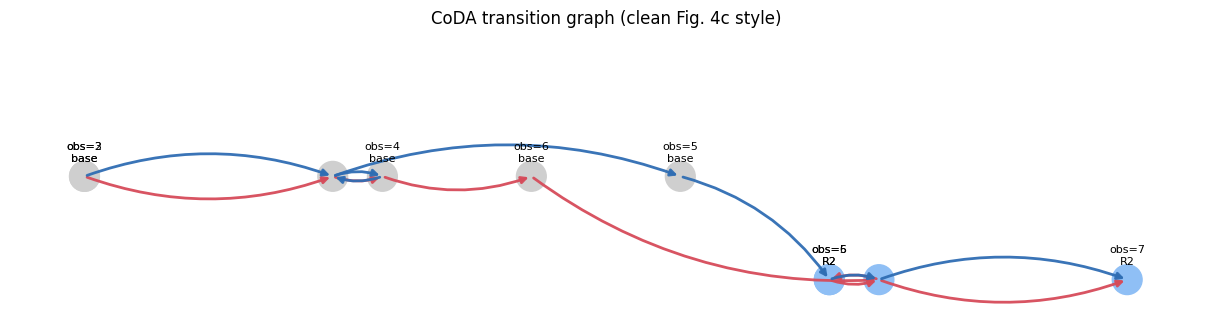

In [5]:

# Refit one agent for a canonical, representative graph
agent = CoDAAgent(obs_symbols=sorted(set(near)|set(far)))
rng = np.random.default_rng(0)
for session in range(SESSIONS):
    episodes = [near]*(TRIALS_PER_SESSION//2) + [far]*(TRIALS_PER_SESSION//2)
    rng.shuffle(episodes)
    for ep in episodes:
        agent.run_episode(ep, learn=True)

def compress_path(ts_sid_pairs):
    out=[]; prev=None
    for t,s in ts_sid_pairs:
        if s!=prev:
            out.append((t,s))
            prev=s
    return out

def build_roi(path_sids, start=6, end=22):
    # slice inclusive
    pairs = [(t, path_sids[t]) for t in range(start, end+1)]
    return compress_path(pairs)

near_lat = agent.run_episode(near, learn=False)
far_lat  = agent.run_episode(far, learn=False)

near_roi = build_roi(near_lat, 6, 22)
far_roi  = build_roi(far_lat,  6, 22)

# x positions: order along each compressed path, averaged when a node is in both.
from collections import defaultdict
ord_acc = defaultdict(list)
for i,(_,sid) in enumerate(near_roi): ord_acc[sid].append(i)
for i,(_,sid) in enumerate(far_roi):  ord_acc[sid].append(i)

pos = {}
def y_of(sid):
    path = agent.states[sid].path
    return {None:0.0,'R1':1.0,'R2':-1.0}[path]

for sid in ord_acc:
    x = np.mean(ord_acc[sid])
    pos[sid] = (x, y_of(sid))

# Edges between consecutive compressed states (u!=v), per path
near_edges = [(near_roi[i][1], near_roi[i+1][1]) for i in range(len(near_roi)-1) if near_roi[i][1]!=near_roi[i+1][1]]
far_edges  = [(far_roi[i][1],  far_roi[i+1][1])  for i in range(len(far_roi)-1)  if far_roi[i][1]!=far_roi[i+1][1]]

# Draw
fig, ax = plt.subplots(figsize=(12,3.2), constrained_layout=True)

# Nodes
node_list = sorted(pos.keys(), key=lambda s: pos[s][0])
node_colors = []
for sid in node_list:
    path = agent.states[sid].path
    node_colors.append({None:'#cfcfcf','R1':'#ff9bb0','R2':'#8fbff5'}[path])
nx.draw_networkx_nodes(nx.DiGraph(), pos, nodelist=node_list,
                       node_color=node_colors, node_size=460, ax=ax)

# Edge drawing with curvature
def draw_edges(edges, color, rad):
    for (u,v) in edges:
        con = f'arc3,rad={rad}'
        ax.annotate('', xy=pos[v], xytext=pos[u],
                    arrowprops=dict(arrowstyle='-|>', lw=2.0, color=color, alpha=0.95,
                                    connectionstyle=con))

draw_edges(near_edges, '#d64b5a',  0.18)  # near path
draw_edges(far_edges,  '#2f6db3', -0.18)  # far path

# Labels: only key observations
for sid in node_list:
    obs = agent.states[sid].obs
    if obs in (2,3,4,5,6,7):
        ax.text(pos[sid][0], pos[sid][1]+0.13, f'obs={obs}\n{agent.states[sid].path or "base"}',
                ha='center', va='bottom', fontsize=8)

ax.set_xlim(min(p[0] for p in pos.values())-0.5, max(p[0] for p in pos.values())+0.5)
ax.set_ylim(-1.4, 1.4)
ax.set_title("CoDA transition graph (clean Fig. 4c style)")
ax.axis('off')
plt.show()


## Fig. 4i — Final correlation quantification

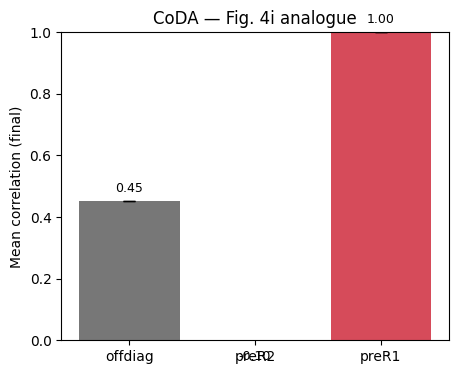

In [6]:

means = blocks_df.mean(); ses = blocks_df.sem()
labels = ['offdiag','preR2','preR1']
x = np.arange(len(labels)); y = [means[l] for l in labels]; yerr = [ses[l] for l in labels]

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0,1.0)
ax.set_ylabel("Mean correlation (final)")
ax.set_title("CoDA — Fig. 4i analogue")
for i,val in enumerate(y): ax.text(i, val+0.03, f"{val:.2f}", ha='center', fontsize=9)
plt.show()


## Fig. 4j — Decorrelation order (time to corr < 0.3)

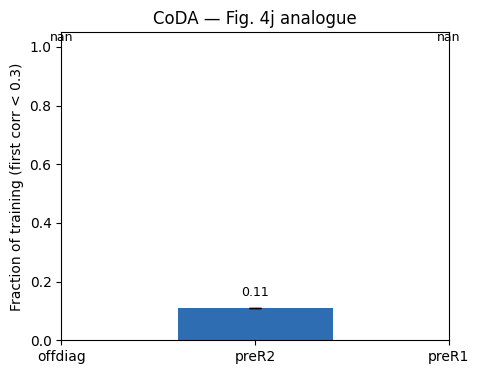

In [7]:

means_t = times_df.mean(skipna=True); ses_t = times_df.sem(skipna=True)
labels = ['offdiag_t','preR2_t','preR1_t']; disp = ['offdiag','preR2','preR1']
x = np.arange(len(labels)); y = [means_t[l] for l in labels]; yerr=[ses_t[l] for l in labels]

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(disp)
ax.set_ylim(0,1.05)
ax.set_ylabel("Fraction of training (first corr < 0.3)")
ax.set_title("CoDA — Fig. 4j analogue")
for i,val in enumerate(y): ax.text(i, min(1.02,val+0.04), f"{val:.2f}", ha='center', fontsize=9)
plt.show()
